# "Silent Speech" Dataset Analysis On Single Set Of Data

This notebook is for data analysis from [David Gaddy's repository](https://github.com/dgaddy/silent_speech) dataset on GitHub.

In the context of Liquid Neural Dynamics (Liquid Neural Networks - LNN) for modeling temporal signals, specifically in applications of EMG-driven speech synthesis, the dataset provided plays a critical role in understanding relationships between muscular signals (EMG), audio signals, and speech events (button presses or annotations).

Temporal alignment between signals, quality of EMG recordings, and cleaned audio are crucial components for training and validating these models.

## Data & Libraries Setup

In [ ]:
import numpy as np
import librosa
import json

root = "../data/silent_speech_dataset/raw/nonparallel_data/4-21/"
index = 150

# Load EMG signals
emg_data = np.load(f'{root}/{index}_emg.npy')
button_data = np.load(f'{root}/{index}_button.npy')

# Load raw and cleaned audio signals
audio_raw, sr_raw = librosa.load(f'{root}/{index}_audio.flac', sr=None)
audio_clean, sr_clean = librosa.load(f'{root}/{index}_audio_clean.flac', sr=None)

# Load metadata
with open(f'{root}/{index}_info.json', 'r') as f:
    info = json.load(f)

## EMG Signal Analysis

### EMG Signal Statistics & Temporal Dynamics

In [31]:
print(f'EMG shape: {emg_data.shape}')
print(f'Mean amplitude: {np.mean(emg_data):.4f}')
print(f'Standard deviation: {np.std(emg_data):.4f}')

EMG shape: (9828, 8)
Mean amplitude: -14423.0182
Standard deviation: 8824.3352


### Visualization

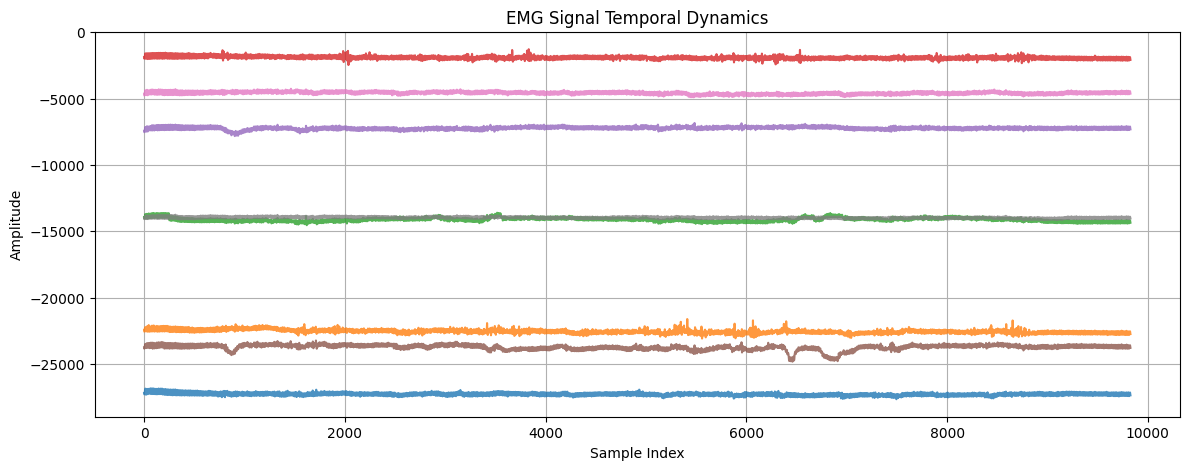

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(emg_data, alpha=0.8)
plt.title('EMG Signal Temporal Dynamics')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

## Correlation between EMG and Audio

In [33]:
def visualize_audio_and_emg(audio_data, sr, title):
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(audio_data, sr=sr)
    plt.title(title)

    plt.subplot(2, 1, 2)
    plt.plot(emg_data, alpha=0.8)
    plt.title('EMG Signal')
    plt.xlabel('Sample Index')

    plt.tight_layout()
    plt.show()

### Raw Audio Visualization

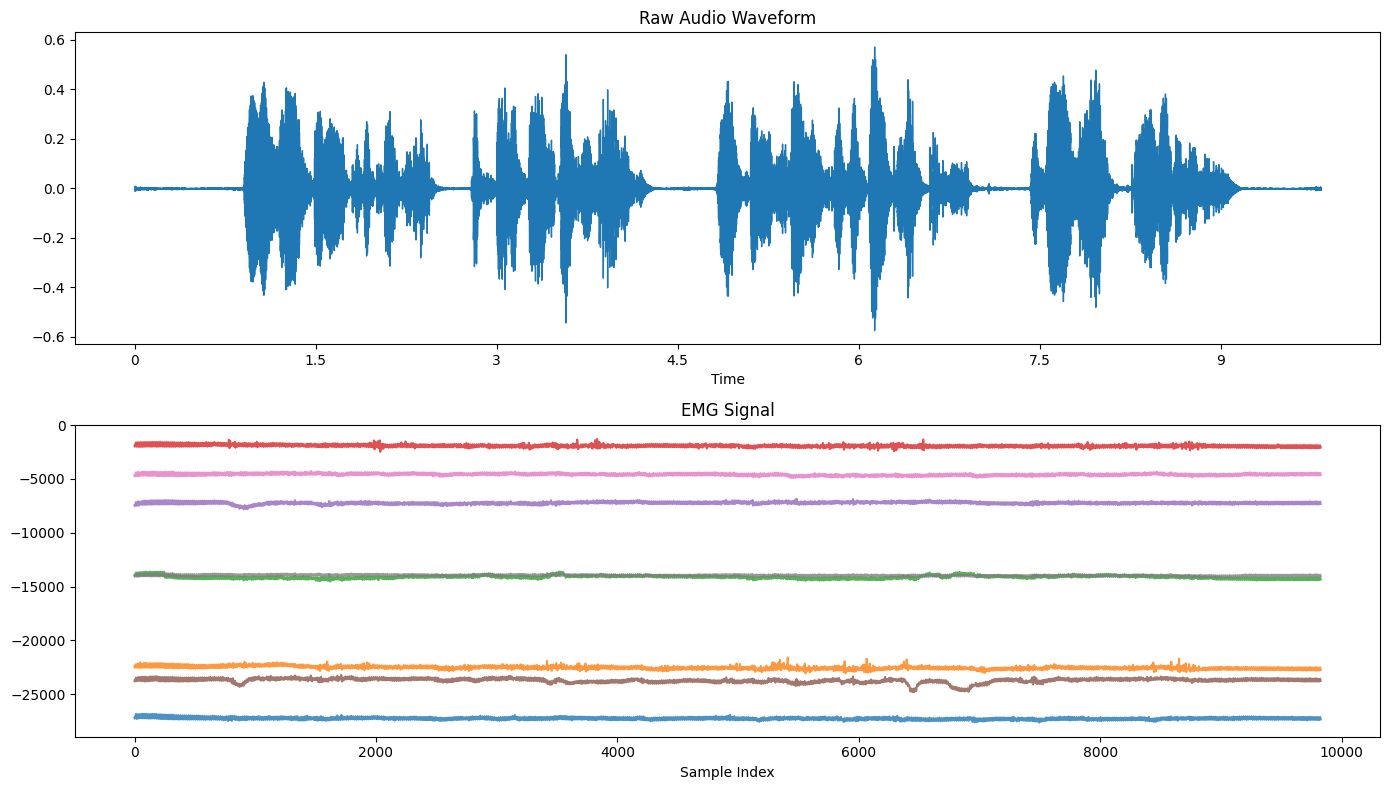

In [34]:
visualize_audio_and_emg(audio_clean, sr_clean, "Raw Audio Waveform")

### Clean Audio Visualization

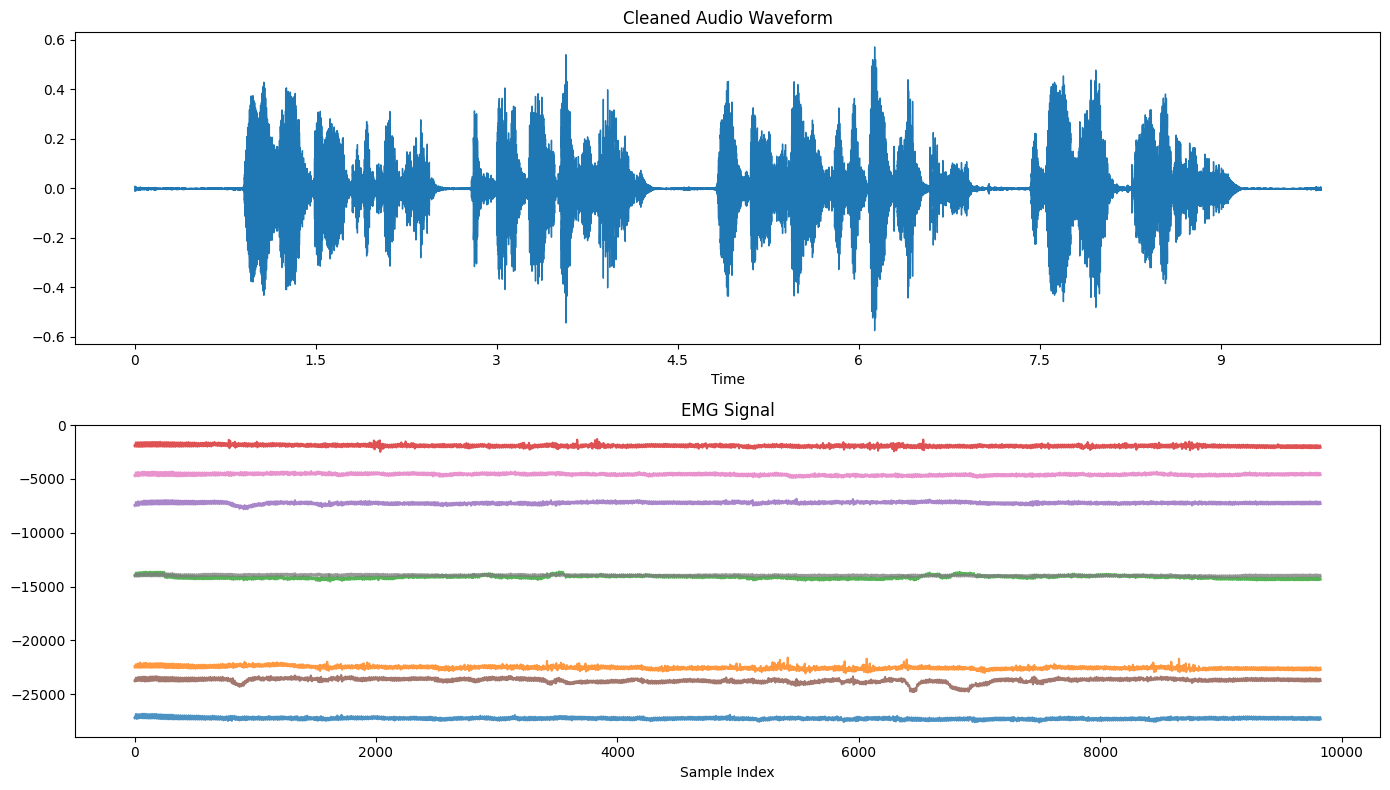

In [35]:
visualize_audio_and_emg(audio_clean, sr_clean, "Cleaned Audio Waveform")

## Button Data & Event Alignment

Button data shape: (9828,)
Button event distribution: {False: 9828}


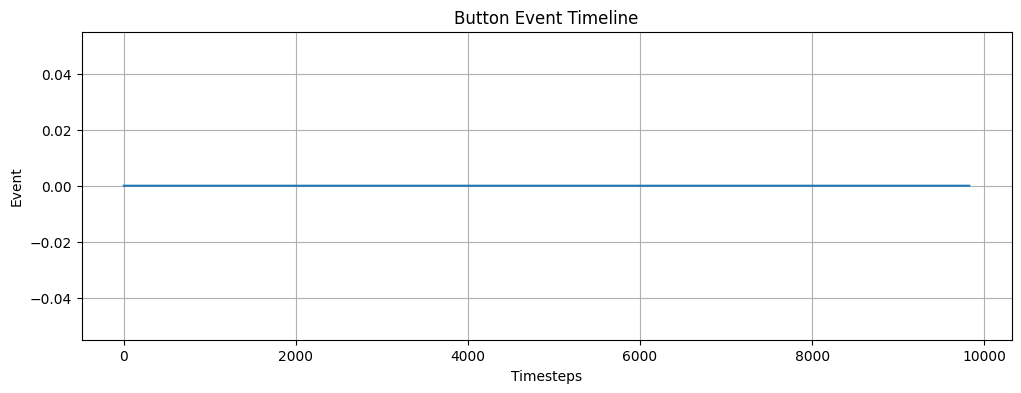

In [36]:
print(f'Button data shape: {button_data.shape}')
unique, counts = np.unique(button_data, return_counts=True)
print(f'Button event distribution: {dict(zip(unique, counts))}')

plt.figure(figsize=(12, 4))
plt.step(range(len(button_data)), button_data, where='pre')
plt.title('Button Event Timeline')
plt.xlabel('Timesteps')
plt.ylabel('Event')
plt.grid(True)
plt.show()

## Metadata Analysis and Chunk Segmentation

In [37]:
print("Sample Text:", info["text"])
print("Chunk count:", len(info["chunks"]))

Sample Text: When you drove home after the concert I called upon Scotland Yard, and upon the chairman of the bank directors, with the result that you have seen.”
Chunk count: 88


**Relevance**: Chunks potentially define segments critical for training EMG-to-speech mapping models using LNN. They provide targets for temporal segmentation.

### Understanding Chunk Data

The chunks field from the metadata looks like this:

In [38]:
info["chunks"]

[[132, 2112, 132],
 [60, 968, 60],
 [66, 976, 66],
 [60, 1029, 60],
 [66, 1053, 66],
 [66, 1062, 66],
 [60, 1032, 60],
 [72, 1026, 72],
 [72, 1107, 72],
 [60, 1123, 60],
 [72, 1114, 72],
 [66, 1131, 66],
 [72, 1125, 72],
 [78, 1123, 78],
 [72, 1184, 72],
 [72, 1163, 72],
 [78, 1197, 78],
 [72, 1203, 72],
 [84, 1253, 84],
 [78, 1251, 78],
 [72, 1269, 72],
 [78, 1259, 78],
 [78, 1338, 78],
 [84, 1272, 84],
 [90, 1326, 90],
 [78, 1410, 78],
 [90, 1390, 90],
 [90, 1458, 90],
 [96, 1408, 96],
 [90, 1475, 90],
 [102, 1512, 102],
 [90, 1533, 90],
 [96, 1531, 96],
 [96, 1616, 96],
 [96, 1539, 96],
 [102, 1592, 102],
 [102, 1664, 102],
 [108, 1685, 108],
 [102, 1683, 102],
 [114, 1674, 114],
 [108, 1800, 108],
 [114, 1720, 114],
 [108, 1827, 108],
 [108, 1829, 108],
 [120, 1894, 120],
 [126, 1877, 126],
 [120, 1960, 120],
 [120, 1968, 120],
 [132, 2027, 132],
 [126, 2098, 126],
 [120, 2008, 120],
 [132, 2038, 132],
 [132, 2162, 132],
 [144, 2112, 144],
 [126, 2168, 126],
 [144, 2187, 144],
 [13

These seem to represent EMG segments as `[start_index, end_index, duration_or_label]`. (Clarification needed: The third value could represent a duration, label, or another descriptor—most logically duration or segment label. Here, we assume it to be either duration or length.)

We'll initially interpret these chunks as `[start, end, duration]`.

### Verify Temporal Consistency (Chunk & EMG Length)

First, verify if chunk indices align properly within the EMG data length:

In [39]:
chunks = np.array(info["chunks"])
print("EMG length:", len(emg_data))
print("Max chunk end index:", chunks[:,1].max())


EMG length: 9828
Max chunk end index: 2395


If the maximum chunk end index is lower than or equal to EMG data length, temporal consistency is valid.

### Visualizing EMG Segments Defined by Chunks

Let's plot several chunk-segmented EMG signals to visually assess whether the chunks align clearly with EMG signal events:

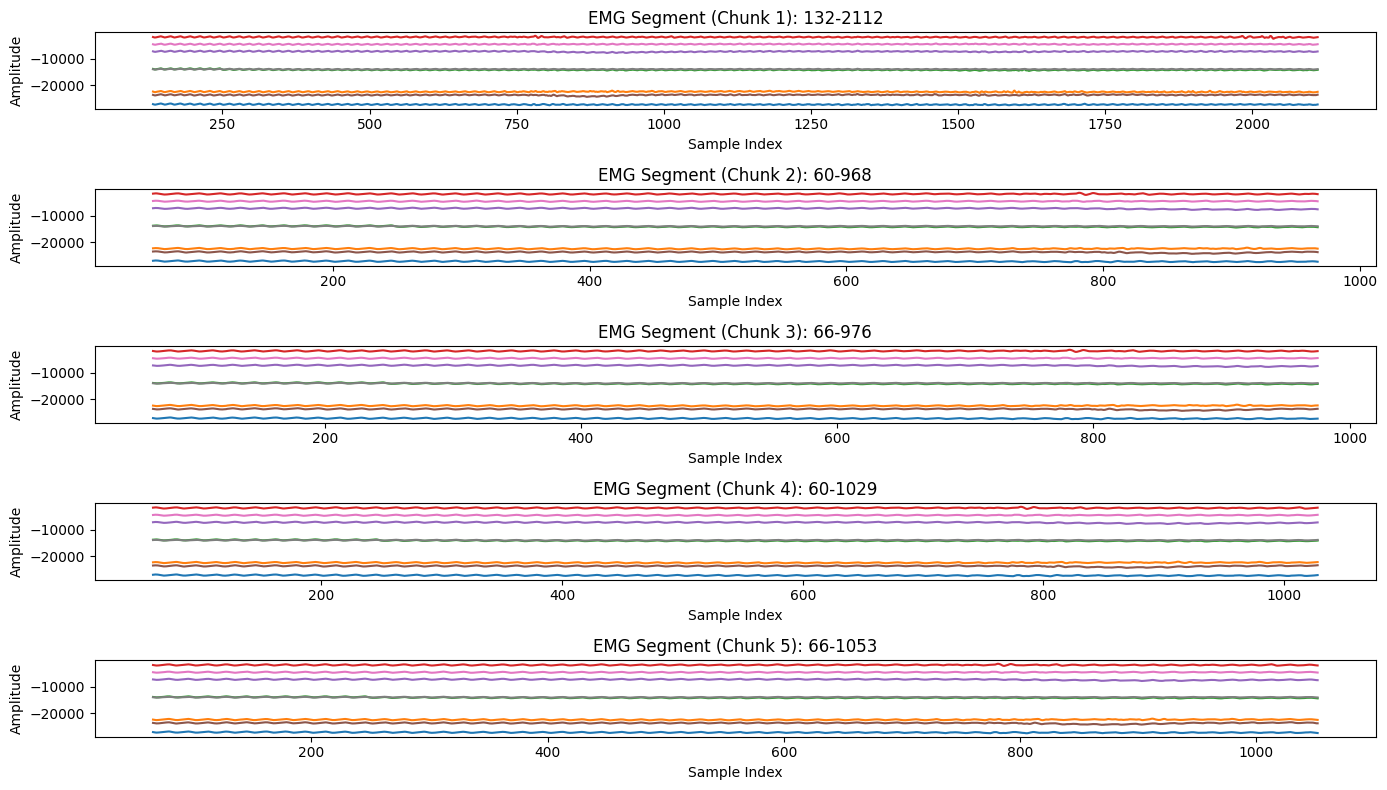

In [40]:
# Select first 5 chunks for visualization
num_chunks = 5
plt.figure(figsize=(14, 8))

for i in range(num_chunks):
    start, end, _ = chunks[i]
    plt.subplot(num_chunks, 1, i+1)
    plt.plot(range(start, end), emg_data[start:end])
    plt.title(f'EMG Segment (Chunk {i+1}): {start}-{end}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

### Statistical Analysis of Chunked EMG Segments

Evaluate basic statistical properties of these segments to identify any clear patterns:

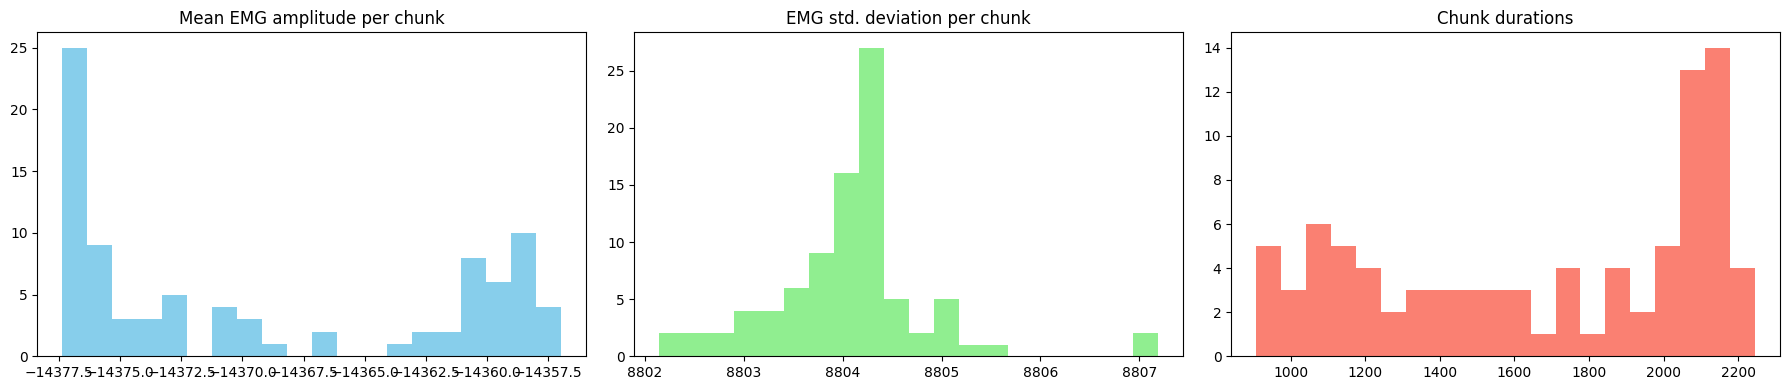

In [41]:
mean_vals, std_vals, duration_vals = [], [], []

for start, end, duration in chunks:
    segment = emg_data[start:end]
    mean_vals.append(np.mean(segment))
    std_vals.append(np.std(segment))
    duration_vals.append(end-start)

fig, axes = plt.subplots(1, 3, figsize=(18,4))

axes[0].hist(mean_vals, bins=20, color='skyblue')
axes[0].set_title('Mean EMG amplitude per chunk')

axes[1].hist(std_vals, bins=20, color='lightgreen')
axes[1].set_title('EMG std. deviation per chunk')

axes[2].hist(duration_vals, bins=20, color='salmon')
axes[2].set_title('Chunk durations')

plt.tight_layout()
plt.show()

**Interpretation**: Clusters or distinct groups might indicate phonetic or linguistic segments.

### Cross-correlation of EMG amplitude & Chunk Length

Check if chunk duration correlates with EMG mean amplitude or variability:

In [42]:
from scipy.stats import pearsonr

corr_mean_duration, _ = pearsonr(mean_vals, duration_vals)
corr_std_duration, _ = pearsonr(std_vals, duration_vals)

print(f'Correlation (mean amplitude vs. chunk duration): {corr_mean_duration:.3f}')
print(f'Correlation (std deviation vs. chunk duration): {corr_std_duration:.3f}')

Correlation (mean amplitude vs. chunk duration): -0.970
Correlation (std deviation vs. chunk duration): 0.062


### Spectral Features of EMG

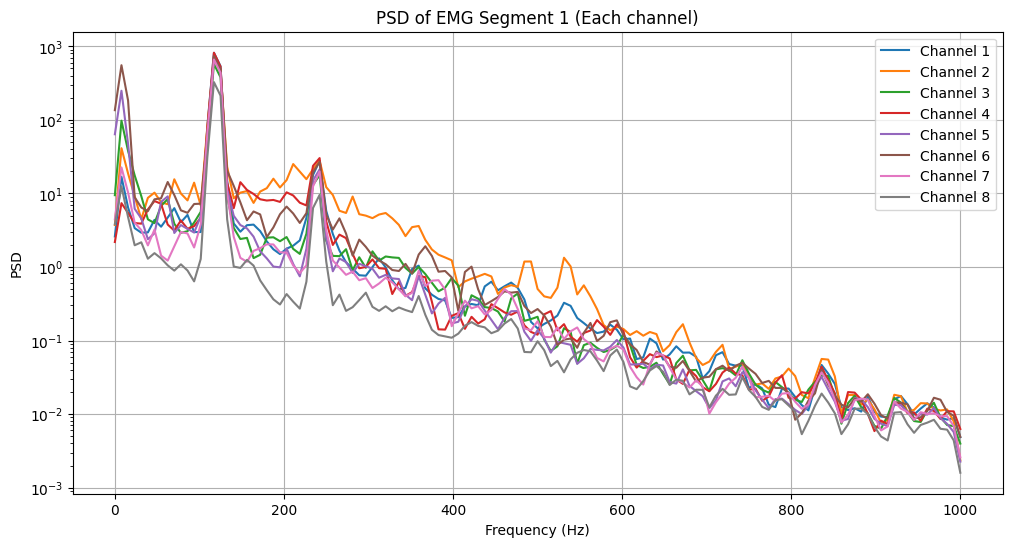

In [43]:
from scipy.signal import welch

chunk_id = 0
start, end, _ = chunks[chunk_id]
segment = emg_data[start:end]

fs = 2000
freqs, psd = welch(segment, fs=fs, axis=0)

# Plot PSD for each channel separately
num_channels = psd.shape[1]

plt.figure(figsize=(12, 6))
for ch in range(num_channels):
    plt.semilogy(freqs, psd[:, ch], label=f'Channel {ch+1}')

plt.title(f'PSD of EMG Segment {chunk_id + 1} (Each channel)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.grid(True)
plt.show()